In [21]:
# Original Coding process

import sqlite3 
import pandas as pd

# Connecting to database.db
conn = sqlite3.connect('/Users/diboshbaruah/Desktop/Database.db')
data = pd.read_sql_query('SELECT * FROM Heart_disease', conn)

print("Displaying first few rows of the dataset")
print()
print(data.head())
print()

# Checking for data types
print("Data types before conversion:")
print(data.dtypes)
print()

# Closing the connection
conn.close()


Displaying first few rows of the dataset

  HeartDisease    BMI Smoking AlcoholDrinking Stroke PhysicalHealth  \
0           No   16.6     Yes              No     No            3.0   
1           No  20.34      No              No    Yes            0.0   
2           No  26.58     Yes              No     No           20.0   
3           No  24.21      No              No     No            0.0   
4           No  23.71      No              No     No           28.0   

  MentalHealth DiffWalking     Sex  AgeCategory   Race Diabetic  \
0         30.0          No                55-59  White      Yes   
1          0.0          No  Female  80 or older  White       No   
2         30.0          No    Male        65-69  White      Yes   
3          0.0          No  Female        75-79  White       No   
4          0.0         Yes  Female        40-44  White       No   

  PhysicalActivity  GenHealth SleepTime Asthma KidneyDisease SkinCancer  
0              Yes                  5.0    Yes        

In [23]:
# Data Pre-processing

# Identifying categorical columns
categorical_columns = ['Smoking', 'AlcoholDrinking', 'Stroke', 'DiffWalking', 'Sex', 'AgeCategory','Race', 
                        'Diabetic', 'PhysicalActivity', 'GenHealth', 'Asthma', 'KidneyDisease', 'SkinCancer']

data_encoded = pd.get_dummies(data, columns=categorical_columns, drop_first=True)

# Converting all boolean columns to integers (0 and 1)
bool_columns = data_encoded.select_dtypes(include='bool').columns
data_encoded[bool_columns] = data_encoded[bool_columns].astype(int)

# Converting 'HeartDisease' from 'Yes'/'No' to 1/0
data_encoded['HeartDisease'] = data_encoded['HeartDisease'].map({'Yes' : 1,'No' : 0})

# Converting 'BMI', 'PhysicalHealth', 'MentalHealth', 'SleepTime' to numeric
data_encoded['BMI'] = pd.to_numeric(data_encoded['BMI'], errors='coerce')
data_encoded['PhysicalHealth'] = pd.to_numeric(data_encoded['PhysicalHealth'], errors='coerce')
data_encoded['MentalHealth'] = pd.to_numeric(data_encoded['MentalHealth'], errors='coerce')
data_encoded['SleepTime'] = pd.to_numeric(data_encoded['SleepTime'], errors='coerce')
                                          
print("Data pre-processing completed successfully...")


Data pre-processing completed successfully...


In [27]:
## Re_checking the first few rows after the encoding
print(data_encoded.head())
print()
print(data_encoded.dtypes)
print()

   HeartDisease    BMI  PhysicalHealth  MentalHealth  SleepTime  Smoking_No  \
0             0  16.60             3.0          30.0        5.0           0   
1             0  20.34             0.0           0.0        7.0           1   
2             0  26.58            20.0          30.0        8.0           0   
3             0  24.21             0.0           0.0        6.0           1   
4             0  23.71            28.0           0.0        8.0           1   

   Smoking_Yes  AlcoholDrinking_Yes  Stroke_Yes  DiffWalking_No  ...  \
0            1                    0           0               1  ...   
1            0                    0           1               1  ...   
2            1                    0           0               1  ...   
3            0                    0           0               1  ...   
4            0                    0           0               0  ...   

   GenHealth_Excellent  GenHealth_Fair  GenHealth_Good  GenHealth_Poor  \
0                 

In [29]:
# Checking for missing values
missing_values = data_encoded.isnull().sum()
print(missing_values[missing_values > 0])



BMI               14710
PhysicalHealth    14710
dtype: int64


In [31]:
# Impute missing values (using median strategy)
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')
data_encoded['BMI'] = imputer.fit_transform(data_encoded[['BMI']])
data_encoded['PhysicalHealth'] = imputer.fit_transform(data_encoded[['PhysicalHealth']])


In [33]:
# Re-checking for missing values post imputation
missing_values = data_encoded.isnull().sum()
print(missing_values)


HeartDisease                        0
BMI                                 0
PhysicalHealth                      0
MentalHealth                        0
SleepTime                           0
Smoking_No                          0
Smoking_Yes                         0
AlcoholDrinking_Yes                 0
Stroke_Yes                          0
DiffWalking_No                      0
DiffWalking_Yes                     0
Sex_Female                          0
Sex_Male                            0
AgeCategory_25-29                   0
AgeCategory_30-34                   0
AgeCategory_35-39                   0
AgeCategory_40-44                   0
AgeCategory_45-49                   0
AgeCategory_50-54                   0
AgeCategory_55-59                   0
AgeCategory_60-64                   0
AgeCategory_65-69                   0
AgeCategory_70-74                   0
AgeCategory_75-79                   0
AgeCategory_80 or older             0
Race_Asian                          0
Race_Black  

In [35]:
# Checking for data set imbalance for HeartDisease column
imbalance_counts = data_encoded['HeartDisease'].value_counts()
print("Imbalance in HeartDisease column:")
print(imbalance_counts)


Imbalance in HeartDisease column:
HeartDisease
0    292422
1     27373
Name: count, dtype: int64


Accuracy: 87.81%

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.87      0.88     58485
           1       0.87      0.89      0.88     58484

    accuracy                           0.88    116969
   macro avg       0.88      0.88      0.88    116969
weighted avg       0.88      0.88      0.88    116969


Confusion Matrix:
[[50691  7794]
 [ 6460 52024]]


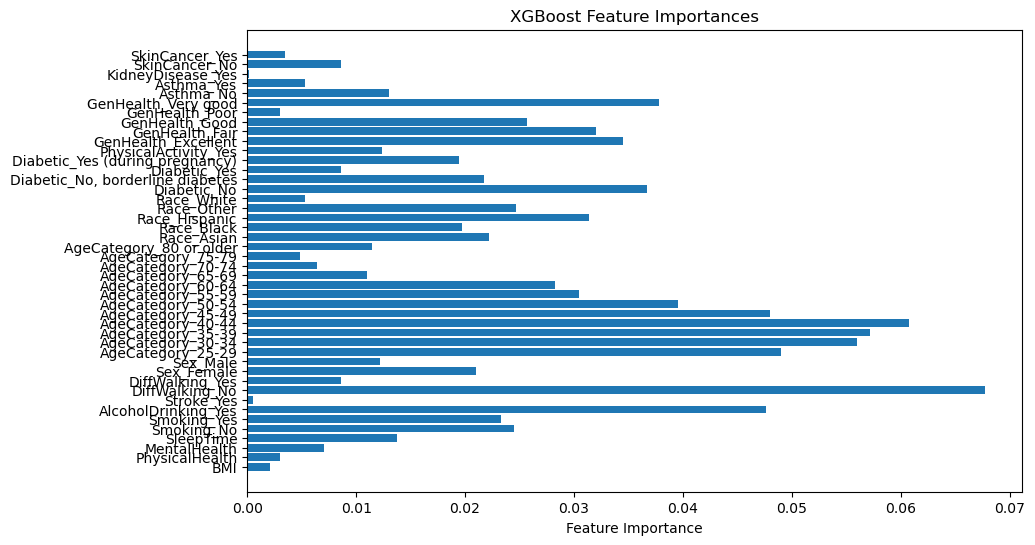

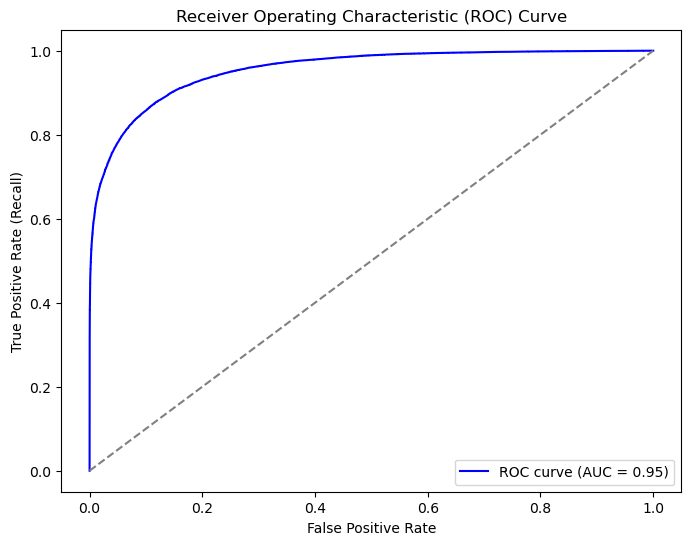

In [37]:
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

# Separate features and target variable
X = data_encoded.drop('HeartDisease', axis=1)
y = data_encoded['HeartDisease']

# Apply SMOTE for oversampling
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Splitting the resampled data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Initialize the XGBoost classifier with tuned parameters
xgb_model = xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, subsample=0.8, random_state=42, eval_metric='mlogloss')

# Training the model on the training data
xgb_model.fit(X_train, y_train)

# Making predictions on the test set
y_pred = xgb_model.predict(X_test)

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
print("\nConfusion Matrix:")
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

# Plotting Feature Importance
importances = xgb_model.feature_importances_
indices = X.columns
plt.figure(figsize=(10, 6))
plt.barh(indices, importances, align='center')
plt.xlabel('Feature Importance')
plt.title('XGBoost Feature Importances')
plt.show()

# ROC Curve
# Getting the predicted probabilities for the positive class (Heart Disease = 1)
y_pred_prob = xgb_model.predict_proba(X_test)[:, 1]

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Calculate AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='b', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


** Now running the saved scripts on jupyter notebook - train_model.py // predict_fraud.py // app.py ***

In [45]:
# Importing the training script
!python train_model.py


Data pre-processing completed successfully.

Model training started using XGBOOST...

Accuracy: 87.81%

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.87      0.88     58485
           1       0.87      0.89      0.88     58484

    accuracy                           0.88    116969
   macro avg       0.88      0.88      0.88    116969
weighted avg       0.88      0.88      0.88    116969


Confusion Matrix:
[[50691  7794]
 [ 6460 52024]]

Model saved as 'xgb_model.pkl'


In [49]:
# Importing the Predict script
!python predict_model.py


Prediction Results...

Prediction (Raw Output): Yes
Prediction Probability (Heart Disease): 0.5064
Prediction Probability (No Heart Disease): 0.4936


In [59]:
import subprocess

# Now running the Flask app using subprocess
subprocess.Popen(["python", "app.py"])

<Popen: returncode: None args: ['python', 'app.py']>

In [69]:
import requests

# Define the URL of the Flask API
url = "http://127.0.0.1:5000/predict"

# Sample data for prediction
data = {
    'BMI': 25.0,
    'Smoking_Yes': 0,
    'AgeCategory_40-44': 1,
    'GenHealth_Poor': 0,
    'PhysicalActivity_Yes': 1,
    'Asthma_Yes': 0,
    'KidneyDisease_Yes': 0
}

# Send a POST request to the Flask API
try:
    response = requests.post(url, json=data)

    # Print the response from the API
    if response.status_code == 200:
        response_data = response.json()
        prediction = "Yes" if response_data['prediction'] == 1 else "No"
        print("Prediction Results:")
        print(f"Prediction: {prediction}")
        print(f"Probability of Heart Disease: {response_data['probability_heart_disease']:.4f}")
        print(f"Probability of No Heart Disease: {response_data['probability_no_heart_disease']:.4f}")
    else:
        print(f"Failed to receive valid response. Status code: {response.status_code}")

except requests.exceptions.RequestException as e:
    print(f"Error making request: {e}")


Prediction Results:
Prediction: No
Probability of Heart Disease: 0.5064
Probability of No Heart Disease: 0.4936


127.0.0.1 - - [04/Feb/2025 01:40:09] "POST /predict HTTP/1.1" 200 -
